In [10]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import bemcs
import bemcs.kernels_stress_displacement as kernels

np.random.seed(43)


## Implementing continuity and smoothness of slip

- For non-planar faults, implementing continuity & differentiability of slip implies we need to deal with a slip vector instead of a scalar, as we have done so far.
- For continuity of slip, we can enforce that the slip vector from patch 1 is equal to the slip vector from patch 2 for a given node $k$  

$\begin{equation} \begin{bmatrix} s_{1_x} \\ s_{1_y} \end{bmatrix}_k= \begin{bmatrix} s_{2_x} \\ s_{2_y} \end{bmatrix}_k \end{equation}$ 

- For smoothness of slip, we state that only the gradient of the slip vector taken along the fault direction ($\zeta$ is a scalar in the dip direction) is relevant i.e., $\frac{\partial s_x}{\partial\zeta},\frac{\partial s_y}{\partial\zeta}$ 

$\begin{equation} \begin{bmatrix} \frac{\partial s_x}{\partial\zeta_1} \\ \frac{\partial s_y}{\partial\zeta_1} \end{bmatrix}_k= \begin{bmatrix} \frac{\partial s_x}{\partial\zeta_2} \\ \frac{\partial s_y}{\partial\zeta_2} \end{bmatrix}_k \end{equation}$

### Planar fault elements

For the simplest case of co-planar elements/patches aligned with $\hat{x},\hat{y}$ axes, the slip components in the local coordinate system are identical to the global coordinates $\begin{bmatrix} s_x \\ s_y \end{bmatrix} = \begin{bmatrix} s_s \\ s_n \end{bmatrix}$. Slip continuity and smoothness over the node $k$ results in 2 sets of coupled equations, where the coupling is between each slip component and its gradient, but not across slip components. 

$\begin{align} \begin{bmatrix} s_{1_s} = s_{2_s} \\ 
\frac{\partial s_s}{\partial\zeta_1} =  \frac{\partial s_s}{\partial\zeta_2}\end{bmatrix}_k \\
\begin{bmatrix} s_{1_n} = s_{2_n} \\ 
\frac{\partial s_n}{\partial\zeta_1} = \frac{\partial s_n}{\partial\zeta_2} \end{bmatrix}_k \end{align}$ 

This is what is implemented in [the previous notebook on non-uniform sized planar patches](Nonuniform_planarpatches.ipynb) for $s_s$ alone while setting $s_n = 0$ for all patches.

## Non-planar fault elements
For non-planar elements/patches, $\begin{bmatrix} s_x \\ s_y \end{bmatrix} = \begin{bmatrix} s_sd_x + s_nn_x \\ s_sd_y + s_nn_y \end{bmatrix}$ where $\hat{d} = (d_x,d_y)$ is the unit vector in the patch dip direction while $\hat{n} = (n_x,n_y)$ is the unit vector in the patch normal direction.

### Continuity of Slip
The equations for continuity of slip for 2 non-planar patches with orientations $\hat{d}_1,\hat{n}_1 = (d_{1_x},d_{1_y}),(n_{1_x},n_{1_y})$ and $\hat{d}_2,\hat{n}_2 = (d_{2_x},d_{2_y}),(n_{2_x},n_{2_y})$, are as follows: 

$\begin{equation} \begin{bmatrix} s_{1_s}d_{1_x} + s_{1_n}n_{1_x} \\ s_{1_s}d_{1_y} + s_{1_n}n_{1_y} \end{bmatrix} = \begin{bmatrix} s_{2_s}d_{2_x} + s_{2_n}n_{2_x} \\ s_{2_s}d_{2_y} + s_{2_n}n_{2_y} \end{bmatrix} \end{equation}$

In terms of quadratic coefficients, the equation relating the three coefficients per fault element in shear and tensile directions $\left(q_s^{a,b,c},q_n^{a,b,c}\right)$, where $(a,b,c)$ are the 3 quadratic basis functions, and slip vector $\left(s_x,s_y\right)$ at a given point is 

$\begin{equation}\begin{bmatrix} s_x \\ s_y \end{bmatrix} = \begin{bmatrix} d_x & n_x \\ d_y & n_y \end{bmatrix} \begin{bmatrix} f_1 & f_2 & f_3 & 0 & 0 & 0\\ 0 & 0 & 0 & f_1 & f_2 & f_3\end{bmatrix} \begin{bmatrix} q_s^a \\ q_s^b \\ q_s^c \\ q_n^a \\ q_n^b \\ q_n^c\end{bmatrix}\end{equation}$

For a 2 fault element system, slip at the common internal node evaluated using all quadratic coefficients can be written as follows:
$\begin{equation} 
\begin{bmatrix} d_x^1 & n_x^1 & 0 & 0\\ d_y^1 & n_y^1 & 0 & 0\\ 
0 & 0 & d_x^2 & n_x^2 \\ 0 & 0 & d_y^2 & n_y^2 \end{bmatrix} 
\begin{bmatrix} f_1^1 & f_2^1 & f_3^1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\ 
0 & 0 & 0 & f_1^1 & f_2^1 & f_3^1 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & f_1^2 & f_2^2 & f_3^2 & 0 & 0 & 0\\ 
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & f_1^2 & f_2^2 & f_3^2
\end{bmatrix} 
\begin{bmatrix} q_s^{1a} \\ q_s^{1b} \\ q_s^{1c} \\ q_n^{1a} \\ q_n^{1b} \\ q_n^{1c} \\
q_s^{2a} \\ q_s^{2b} \\ q_s^{2c} \\ q_n^{2a} \\ q_n^{2b} \\ q_n^{2c} \end{bmatrix} = 
\begin{bmatrix} s_{1_x} \\ s_{1_y} \\ s_{2_x} \\ s_{2_y} \end{bmatrix}
\end{equation}$

After multiplying and manipulating the rows, the design matrix for continuity of slip is:
$\begin{equation}
\begin{bmatrix} 
f_1^1d_x^1 & f_2^1d_x^1 & f_3^1d_x^1 & f_1^1n_x^1 & f_2^1n_x^1 & f_3^1n_x^1 & 0 & 0 & 0 & 0 & 0 & 0\\ 
f_1^1d_y^1 & f_2^1d_y^1 & f_3^1d_y^1 & f_1^1n_y^1 & f_2^1n_y^1 & f_3^1n_y^1 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & f_1^2d_x^2 & f_2^2d_x^2 & f_3^2d_x^2 & f_1^2n_x^2 & f_2^2n_x^2 & f_3^2n_x^2\\ 
0 & 0 & 0 & 0 & 0 & 0 & f_1^2d_y^2 & f_2^2d_y^2 & f_3^2d_y^2 & f_1^2n_y^2 & f_2^2n_y^2 & f_3^2n_y^2
\end{bmatrix}
\end{equation}$

This gives a system of equations, 

$\begin{equation}
\begin{bmatrix} 0 \\ 0 \end{bmatrix} = 
\begin{bmatrix} 
f_1^1d_x^1 & f_2^1d_x^1 & f_3^1d_x^1 & f_1^1n_x^1 & f_2^1n_x^1 & f_3^1n_x^1 & -f_1^2d_x^2 & -f_2^2d_x^2 & -f_3^2d_x^2 & -f_1^2n_x^2 & -f_2^2n_x^2 & -f_3^2n_x^2\\ 
f_1^1d_y^1 & f_2^1d_y^1 & f_3^1d_y^1 & f_1^1n_y^1 & f_2^1n_y^1 & f_3^1n_y^1 & 
-f_1^2d_y^2 & -f_2^2d_y^2 & -f_3^2d_y^2 & -f_1^2n_y^2 & -f_2^2n_y^2 & -f_3^2n_y^2\\
\end{bmatrix} 
\begin{bmatrix} q_s^{1a} \\ q_s^{1b} \\ q_s^{1c} \\ q_n^{1a} \\ q_n^{1b} \\ q_n^{1c} \\
q_s^{2a} \\ q_s^{2b} \\ q_s^{2c} \\ q_n^{2a} \\ q_n^{2b} \\ q_n^{2c} \end{bmatrix}
\end{equation}$

### Smoothness of slip
To keep slip smooth on either side of a node we need to enforce that the gradient of the slip vector in the $\hat{d}$ direction coming from either side of the node is equal. This makes us only have to deal with $\frac{\partial s_x}{\partial\zeta},\frac{\partial s_y}{\partial\zeta}$. In terms of shear and tensile slip components, we have

$\begin{equation}
\begin{bmatrix} \frac{\partial s_x}{\partial\zeta} \\ \frac{\partial s_y}{\partial\zeta} \end{bmatrix} = 
\begin{bmatrix} \frac{\partial s_s}{\partial\zeta}d_x + \frac{\partial s_n}{\partial\zeta}n_x \\ \frac{\partial s_s}{\partial\zeta}d_y + \frac{\partial s_n}{\partial\zeta}n_y \end{bmatrix}
\end{equation}$

This is similar to what we had for the slip vector, and so we can get a nearly identical set of equations for slip gradients for a 2 element system.
$\begin{equation}
\begin{bmatrix} 0 \\ 0 \end{bmatrix} = 
\begin{bmatrix} 
\frac{\partial f_1}{\partial \zeta_1}d_x^1 & \frac{\partial f_2}{\partial\zeta_1}d_x^1 & \frac{\partial f_3}{\partial \zeta_1}d_x^1 & \frac{\partial f_1}{\partial \zeta_1}n_x^1 & \frac{\partial f_2}{\partial\zeta_1}n_x^1 & \frac{\partial f_3}{\partial \zeta_1}n_x^1 & 
-\frac{\partial f_1}{\partial \zeta_2}d_x^2 & -\frac{\partial f_2}{\partial\zeta_2}d_x^2 & -\frac{\partial f_3}{\partial \zeta_2}d_x^2 & -\frac{\partial f_1}{\partial \zeta_2}n_x^2 & -\frac{\partial f_2}{\partial\zeta_2}n_x^2 & -\frac{\partial f_3}{\partial \zeta_2}n_x^2 \\ 
\frac{\partial f_1}{\partial \zeta_1}d_y^1 & \frac{\partial f_2}{\partial\zeta_1}d_y^1 & \frac{\partial f_3}{\partial \zeta_1}d_y^1 & \frac{\partial f_1}{\partial \zeta_1}n_y^1 & \frac{\partial f_2}{\partial\zeta_1}n_y^1 & \frac{\partial f_3}{\partial \zeta_1}n_y^1 & 
-\frac{\partial f_1}{\partial \zeta_2}d_y^2 & -\frac{\partial f_2}{\partial\zeta_2}d_y^2 & -\frac{\partial f_3}{\partial \zeta_2}d_y^2 & -\frac{\partial f_1}{\partial \zeta_2}n_y^2 & -\frac{\partial f_2}{\partial\zeta_2}n_y^2 & -\frac{\partial f_3}{\partial \zeta_2}n_y^2\\
\end{bmatrix} 
\begin{bmatrix} q_s^{1a} \\ q_s^{1b} \\ q_s^{1c} \\ q_n^{1a} \\ q_n^{1b} \\ q_n^{1c} \\
q_s^{2a} \\ q_s^{2b} \\ q_s^{2c} \\ q_n^{2a} \\ q_n^{2b} \\ q_n^{2c} \end{bmatrix}
\end{equation}$


Forcing slip vector at patch centers to be purely shear


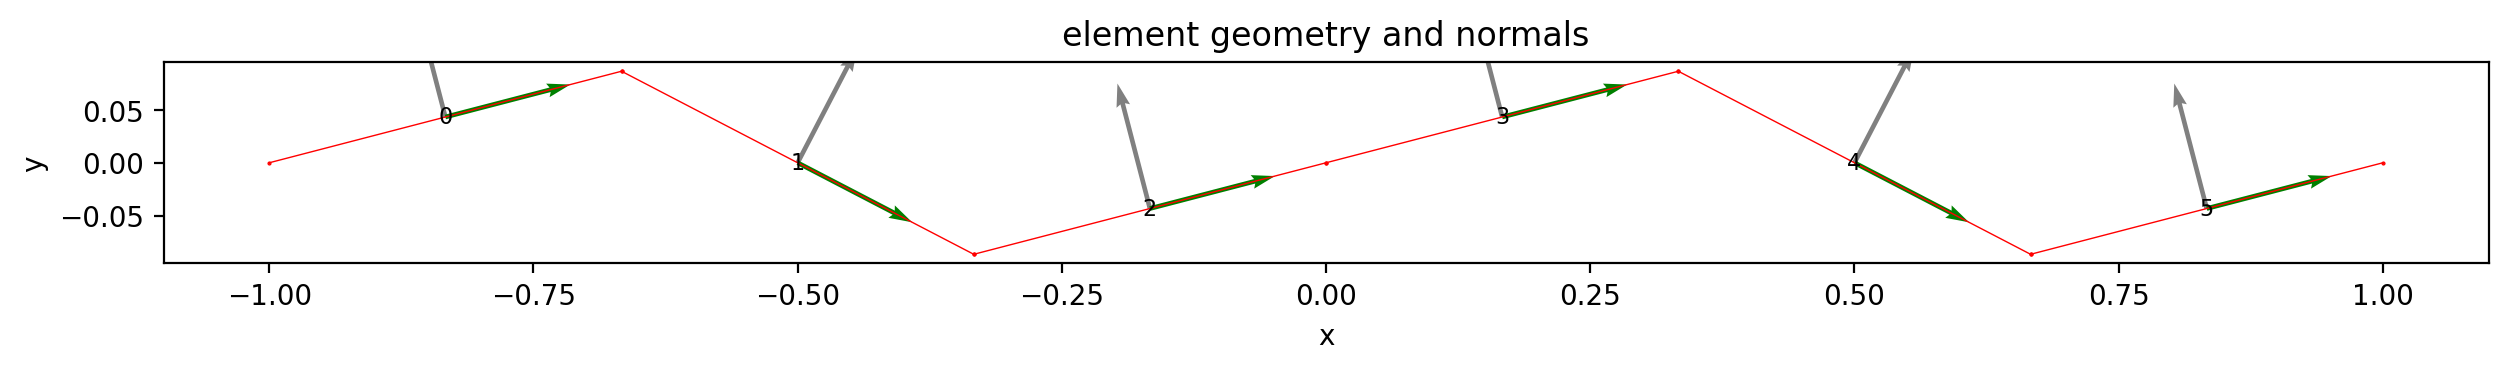

In [12]:
# use a non-uniform mesh
n_elements = 6
# sorted_xlocs = np.sort(np.random.uniform(size=n_elements-1,low=-0.7,high=0.9))
sorted_xlocs = np.linspace(-1 + 2 / n_elements, 1 - 2 / n_elements, n_elements - 1)
sorted_ylocs = np.random.uniform(size=n_elements - 1, low=-0.2, high=0.2)
# try a wavy fault
sorted_ylocs = 0.1 * np.sin(4 * np.pi * sorted_xlocs / 2)
# flag for slip to be purely shear
slip_purely_shear = True

# rough fault
x1 = np.concatenate((np.array([-1.0]), sorted_xlocs))
x2 = np.concatenate((sorted_xlocs, np.array([1.0])))
y1 = np.concatenate((np.array([0.0]), sorted_ylocs))
y2 = np.concatenate((sorted_ylocs, np.array([0.0])))

elements = []
element = {}
for i in range(n_elements):
    element["x1"] = x1[i]
    element["y1"] = y1[i]
    element["x2"] = x2[i]
    element["y2"] = y2[i]
    elements.append(element.copy())
elements = bemcs.standardize_elements(elements)

# slip imposed at central nodes of each patch (these are in x,y coordinates)
# slip_vector_x = np.random.uniform(size=n_elements,low = 0.5, high = 1.0)*0
# slip_vector_y = np.random.uniform(size=n_elements,low = 0.5, high = 1.0)
slip_vector_x = (
    1 - np.linspace(-1, 1, n_elements) ** 2
)  # + np.random.uniform(size=n_elements,low = -0.1, high = 0.1)
slip_vector_y = np.random.uniform(size=n_elements, low=-0.2, high=0.2) * 0

# force slip vector to be purely shear (s_n = 0)
if slip_purely_shear == True:
    slip_vector = np.vstack((slip_vector_x, slip_vector_y * 0)).T
    print("Forcing slip vector at patch centers to be purely shear")
    for i in range(len(elements)):
        slip_vector_x[i], slip_vector_y[i] = (
            slip_vector[i, :] @ elements[i]["inverse_rotation_matrix"]
        )
        # print(slip_vector[i,:])
        # print(slip_vector_x[i],slip_vector_y[i])

# slip_vector_x = np.array((0.5,0.,0.5))
# slip_vector_y = np.array((0.,-1.,0.))

# plot geometry of mesh
plt.figure(figsize=(15, 5))
bemcs.plot_element_geometry(elements)


## Design matrix and boundary conditions for the system

- We seek a solution to a system of equations $L.q = b$, where $L$ is the design matrix, $q$ is a vector of quadratic nodal coefficients and $b$ is a vector of boundary conditions. 
- The system is constructed for $N_p$ straight line elements that are used to discretize an arbitrary line.

### Unknowns
- $3\times N_p$ unknown $q_s$ coefficients + $3\times N_p$ unknown $q_n$ coefficients = $6\times N_p$ unknowns
### Equations and constraints
- $N_p$ slip values at element centers for $s_s$ (shear slip)
- $N_p$ slip values at element centers for $s_n$ (tensile slip)
- $2\times(N_p-1)$ equations for continuity of the slip vector at internal nodes (common to 2 elements)
- $2\times(N_p-1)$ equations for smoothness/differentiability of the slip vector at internal nodes (common to 2 elements)
- $2 \times 2$ equations for either the slip vector or gradient of the slip vector at the boundary nodes



### Boundary conditions
For $N$ elements/patches, each having 3 nodes ($n_1,n_2,n_3$), we have $6N$ equations:

1. patch<sub>1</sub>(n<sub>1</sub>)grad<sub>x</sub> = 0
2. patch<sub>1</sub>(n<sub>1</sub>)grad<sub>y</sub> = 0
3. patch<sub>1</sub>(n<sub>2</sub>)<sub>x</sub> = $(u_1)_x$
4. patch<sub>1</sub>(n<sub>2</sub>)<sub>y</sub> = $(u_1)_y$
5. patch<sub>1</sub>(n<sub>3</sub>)<sub>x</sub> = patch<sub>2</sub>(n<sub>1</sub>)<sub>x </sub> (continuity)
6. patch<sub>1</sub>(n<sub>3</sub>)<sub>y</sub> = patch<sub>2</sub>(n<sub>1</sub>)<sub>y </sub> (continuity)
7. patch<sub>1</sub>(n<sub>3</sub>)grad<sub>x</sub> = patch<sub>2</sub>(n<sub>1</sub>)grad<sub>x</sub> (smoothness)
8. patch<sub>1</sub>(n<sub>3</sub>)grad<sub>y</sub> = patch<sub>2</sub>(n<sub>1</sub>)grad<sub>y</sub> (smoothness)
9. patch<sub>2</sub>(n<sub>2</sub>)<sub>x</sub> = $(u_2)_x$ 
10. patch<sub>2</sub>(n<sub>2</sub>)<sub>y</sub> = $(u_2)_y$
11. patch2(n3)_x = patch3(n1)_x, 
12. patch2(n3)_y = patch3(n1)_y,
13. patch2(n3)grad_x = patch3(n1)grad_x, 
14. patch2(n3)grad_y = patch3(n1)grad_y
15. patch<sub>3</sub>(n<sub>2</sub>)<sub>x</sub> = $(u_3)_x$
16. patch<sub>3</sub>(n<sub>2</sub>)<sub>y</sub> = $(u_3)_y$
17. .......
18. patch<sub>N-1</sub>(n<sub>3</sub>)grad<sub>x</sub> = patch<sub>N</sub>(n<sub>1</sub>)grad<sub>x</sub>
19. patch<sub>N-1</sub>(n<sub>3</sub>)grad<sub>y</sub> = patch<sub>N</sub>(n<sub>1</sub>)grad<sub>y</sub>
20. patch<sub>N</sub>(n<sub>2</sub>)<sub>x</sub> = $(u_N)_x$
21. patch<sub>N</sub>(n<sub>2</sub>)<sub>y</sub> = $(u_N)_y$
22. patch<sub>N</sub>(n<sub>3</sub>)grad<sub>x</sub> = 0
23. patch<sub>N</sub>(n<sub>3</sub>)grad<sub>y</sub> = 0

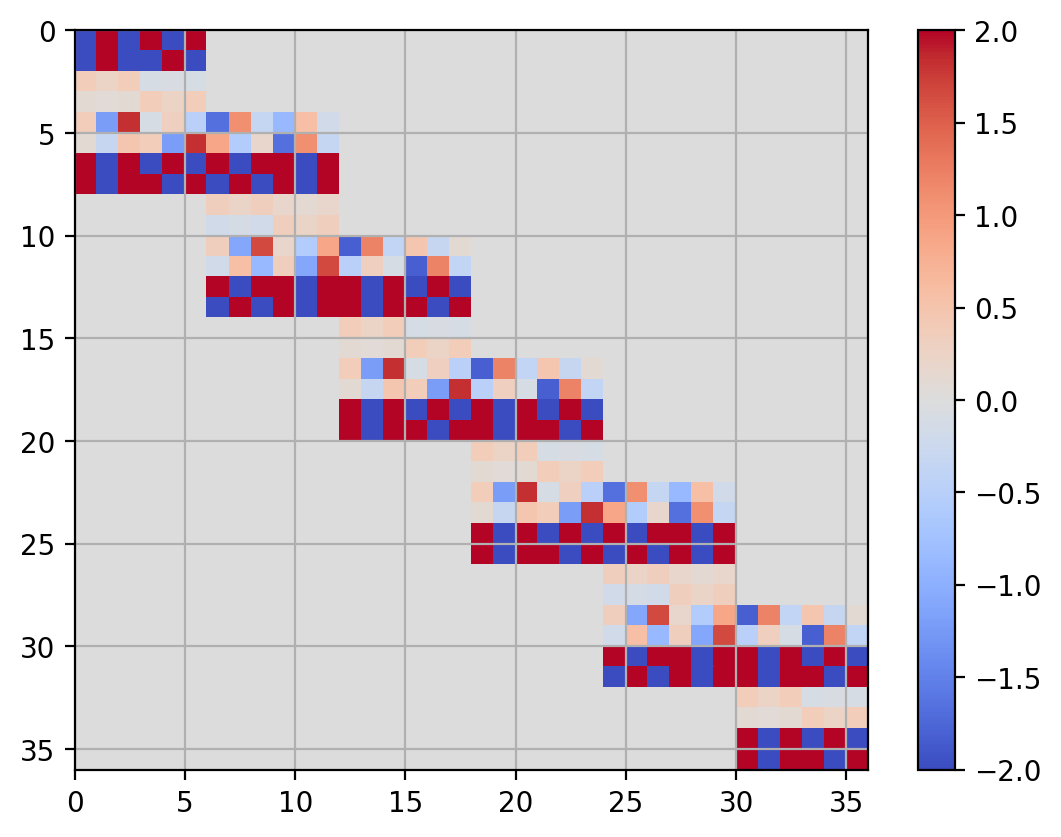

[[-0.082109   -0.02239336  0.09703791  0.12706252  0.03465341 -0.15016479]
 [ 0.47578451  0.69000792  0.77087688 -0.1140502  -0.05669636  0.15184777]
 [ 0.85977661  0.98312847  1.0448044  -0.15016479  0.03465341  0.12706252]
 [ 1.0448044   0.98312847  0.85977661  0.12706252  0.03465341 -0.15016479]
 [ 0.77087688  0.69000792  0.47578451  0.15184777 -0.05669636 -0.1140502 ]
 [ 0.09703791 -0.02239336 -0.082109   -0.15016479  0.03465341  0.12706252]]


In [30]:
# design matrices (in x,y coordinates) for slip and slip gradients at each 3qn
matrix_slip, matrix_slipgradient = kernels.get_designmatrix_xy_3qn(elements,flag="node")
matrix_slip_mean, _ = kernels.get_designmatrix_xy_3qn(elements,flag="mean")

matrix_system = np.zeros((len(elements) * 6, len(elements) * 6))

BCvector = np.zeros((len(elements) * 6, 1))
# slip OR slip gradients at the boundaries (we set them to 0 here)
BCvector[0:2] = 0.0
BCvector[-2:] = 0.0

BCvector[2:-3:6] = slip_vector_x.reshape(-1, 1)
BCvector[3:-2:6] = slip_vector_y.reshape(-1, 1)

# Linear operator for BCs as a matrix
# boundary nodes
matrix_system[0:2,:] = matrix_slipgradient[0:2:]
matrix_system[-2:,:] = matrix_slipgradient[-2:,:]
# matrix_system[0:2, :] = matrix_slip[0:2:]
# matrix_system[-2:, :] = matrix_slip[-2:, :]

# patch center nodes (you can make these either nodal slip based or mean slip based)
matrix_system[2:-3:6, :] = matrix_slip_mean[2:-3:6, :]
matrix_system[3:-2:6, :] = matrix_slip_mean[3:-2:6, :]

# overlapping interior nodes (apply slip continuity and smoothness)
# continuity
matrix_system[4:-7:6, :] = (matrix_slip[4:-7:6, :] - matrix_slip[6:-5:6, :])  # x component
matrix_system[5:-6:6, :] = (matrix_slip[5:-6:6, :] - matrix_slip[7:-4:6, :])  # y component
# smoothness
matrix_system[6:-5:6, :] = (matrix_slipgradient[4:-7:6, :] - matrix_slipgradient[6:-5:6, :])  # x component
matrix_system[7:-4:6, :] = (matrix_slipgradient[5:-6:6, :] - matrix_slipgradient[7:-4:6, :])  # y component

# plot design matrix
_, ax = plt.subplots()
pc = ax.pcolor(matrix_system, cmap="coolwarm", shading="flat")
ax.grid(which="both")
ax.invert_yaxis()
pc.set_clim(-2, 2)
plt.colorbar(pc)
plt.show()

# compute quadratic node coefficients (in local (s,n) coordinates)
quadratic_coefs = np.linalg.inv(matrix_system) @ BCvector# quadratic_coefs = np.linalg.lstsq(matrix_system,BCvector)[0]
print(quadratic_coefs.reshape(n_elements,6))
# plt.figure()
# plt.pcolor(quadratic_coefs.reshape(n_elements,6),cmap='coolwarm')
# plt.colorbar()
# plt.clim(-0.5,0.5)
# plt.show()

In [14]:
# extract (s,n) components and store them in 2 separate vectors
quadratic_coefs_s = np.zeros((len(elements) * 3, 1))
quadratic_coefs_n = np.zeros((len(elements) * 3, 1))
for i in range(len(elements)):
    quadratic_coefs_s[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i : 6 * i + 3]
    quadratic_coefs_n[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i + 3 : 6 * (i + 1)]
# print(np.hstack((quadratic_coefs_s,quadratic_coefs_n)))

# print(quadratic_coefs.reshape(n_elements,5)) # this is like a break statement


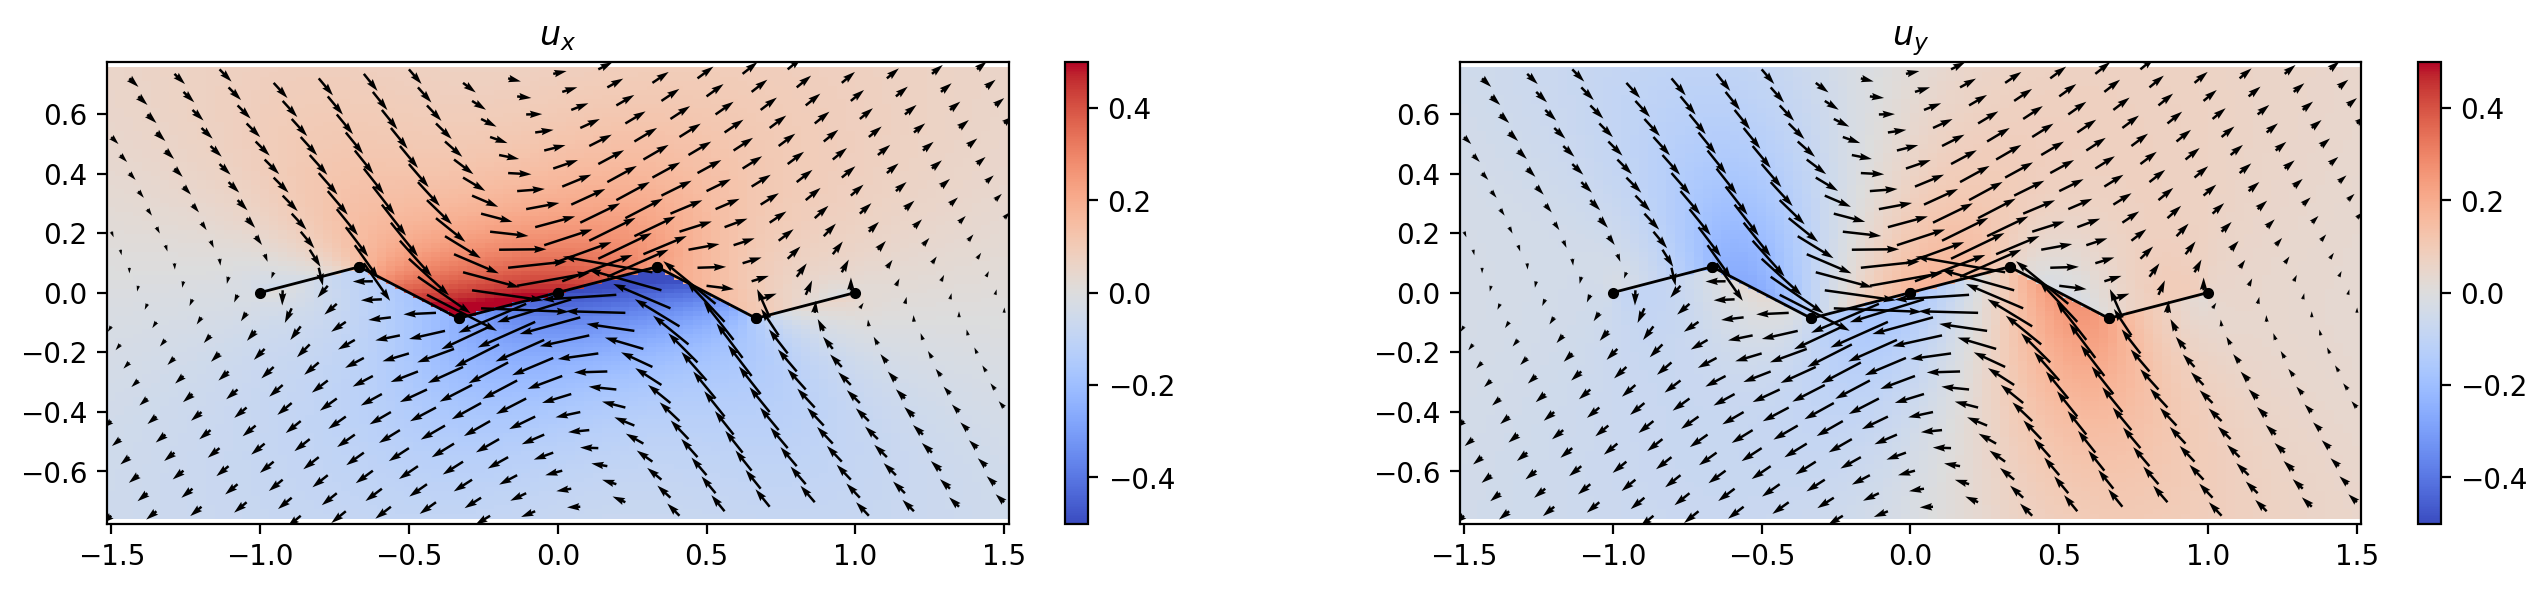

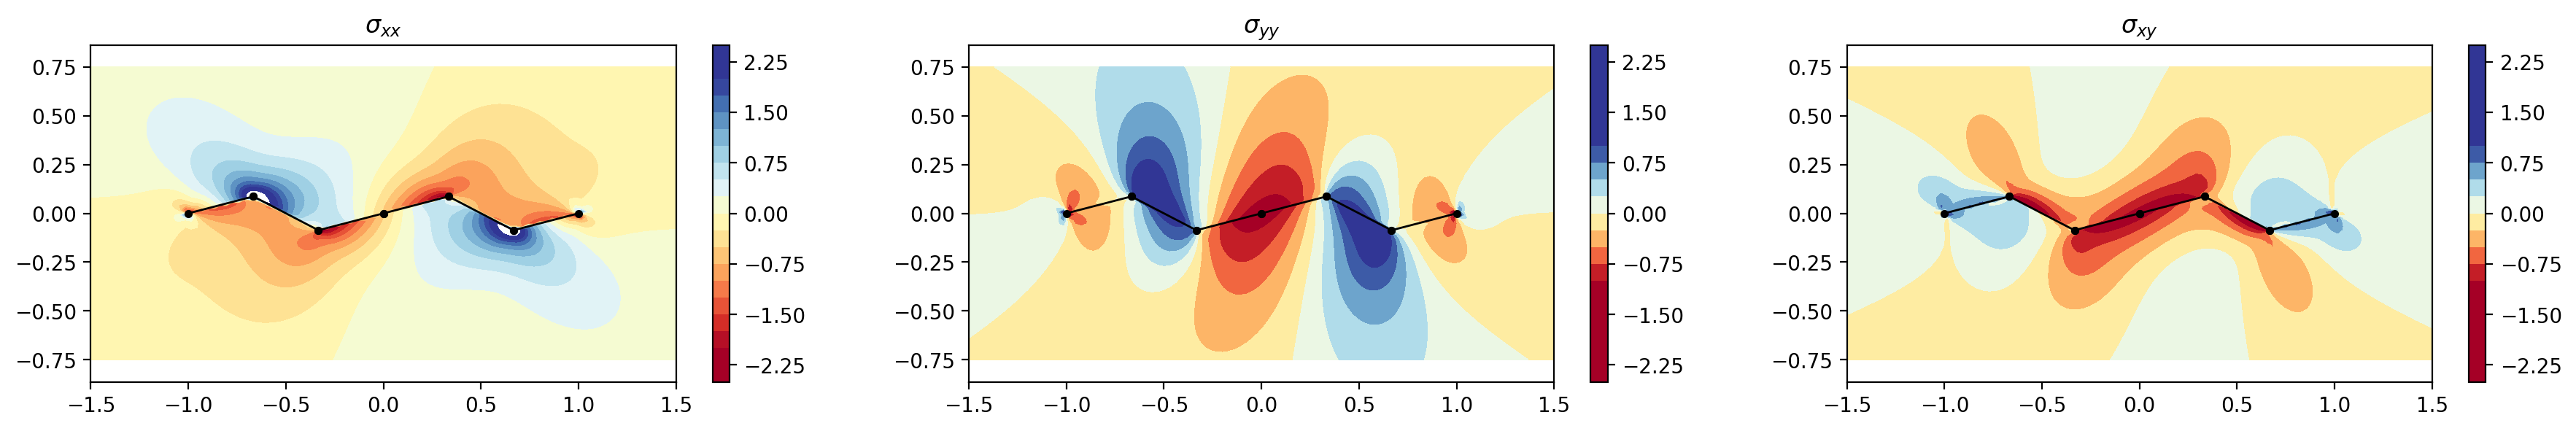

In [15]:
# compute displacement and stress kernels
# Elastic parameters
mu = 1
nu = 0.25
n_obs = 100
width = 1.5
x_obs = np.linspace(-width, width, n_obs)
y_obs = np.linspace(-width / 2, width / 2, n_obs)

x_obs, y_obs = np.meshgrid(x_obs, y_obs)
x_obs = x_obs.flatten()
y_obs = y_obs.flatten()

# compute shear and tensile kernels
# kernels are [Kxx,Kyy,Kxy,Gx,Gy] x [Nobs x Ncoefficients]
# the last argument passed is a flag for shear/tensile source (1 - shear, 0 - tensile)
kernels_s = kernels.get_quadratic_displacement_stress_kernel(
    x_obs, y_obs, elements, mu, nu, 1
)
kernels_n = kernels.get_quadratic_displacement_stress_kernel(
    x_obs, y_obs, elements, mu, nu, 0
)
# plot displacements and stresses
ux = kernels_s[3] @ (quadratic_coefs_s) + kernels_n[3] @ quadratic_coefs_n
uy = kernels_s[4] @ (quadratic_coefs_s) + kernels_n[4] @ quadratic_coefs_n

nskip_plot = 21  # plotting for vectors

# displacements
plt.figure(figsize=(16, 3))
plt.subplot(1, 2, 1)
plt.pcolor(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    ux.reshape(n_obs, n_obs),
    cmap="coolwarm",
)
for element in elements:
    plt.plot(
        [element["x1"], element["x2"]],
        [element["y1"], element["y2"]],
        ".-k",
        linewidth=1.0,
    )
plt.clim(-0.5, 0.5)
plt.colorbar()
plt.quiver(
    x_obs[0::nskip_plot], y_obs[0::nskip_plot], ux[0::nskip_plot], uy[0::nskip_plot]
)
plt.axis("equal")
plt.title("$u_x$")

plt.subplot(1, 2, 2)
plt.pcolor(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    uy.reshape(n_obs, n_obs),
    cmap="coolwarm",
)
for element in elements:
    plt.plot(
        [element["x1"], element["x2"]],
        [element["y1"], element["y2"]],
        ".-k",
        linewidth=1.0,
    )
plt.clim(-0.5, 0.5)
plt.colorbar()
plt.quiver(
    x_obs[0::nskip_plot], y_obs[0::nskip_plot], ux[0::nskip_plot], uy[0::nskip_plot]
)
plt.title("$u_y$")
plt.axis("equal")
plt.show()

# plot stresses
plt.figure(figsize=(22, 3))
plt.subplot(1, 3, 1)
toplot = kernels_s[0] @ (quadratic_coefs_s) + kernels_n[0] @ quadratic_coefs_n
plt.contourf(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    toplot.reshape(n_obs, n_obs),
    levels=np.linspace(-2.5, 2.5, 21),
    cmap="RdYlBu",
    vmin=-1.5,
    vmax=1.5,
)
for element in elements:
    plt.plot(
        [element["x1"], element["x2"]],
        [element["y1"], element["y2"]],
        ".-k",
        linewidth=1.0,
    )
plt.colorbar()
plt.clim(-2, 2)
plt.axis("equal")
plt.title("$\sigma_{xx}$")

plt.subplot(1, 3, 2)
toplot = kernels_s[1] @ quadratic_coefs_s + kernels_n[1] @ quadratic_coefs_n
plt.contourf(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    toplot.reshape(n_obs, n_obs),
    levels=np.linspace(-2.5, 2.5, 21),
    cmap="RdYlBu",
    vmin=-1.5,
    vmax=1.5,
)
for element in elements:
    plt.plot(
        [element["x1"], element["x2"]],
        [element["y1"], element["y2"]],
        ".-k",
        linewidth=1.0,
    )
plt.colorbar()
plt.clim(-1, 1)
plt.axis("equal")
plt.title("$\sigma_{yy}$")

plt.subplot(1, 3, 3)
toplot = kernels_s[2] @ quadratic_coefs_s + kernels_n[2] @ quadratic_coefs_n
plt.contourf(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    toplot.reshape(n_obs, n_obs),
    levels=np.linspace(-2.5, 2.5, 21),
    cmap="RdYlBu",
    vmin=-1.5,
    vmax=1.5,
)
for element in elements:
    plt.plot(
        [element["x1"], element["x2"]],
        [element["y1"], element["y2"]],
        ".-k",
        linewidth=1.0,
    )
plt.colorbar()
plt.clim(-1, 1)
plt.axis("equal")
plt.title("$\sigma_{xy}$")
plt.show()


# Try nine panel visualization

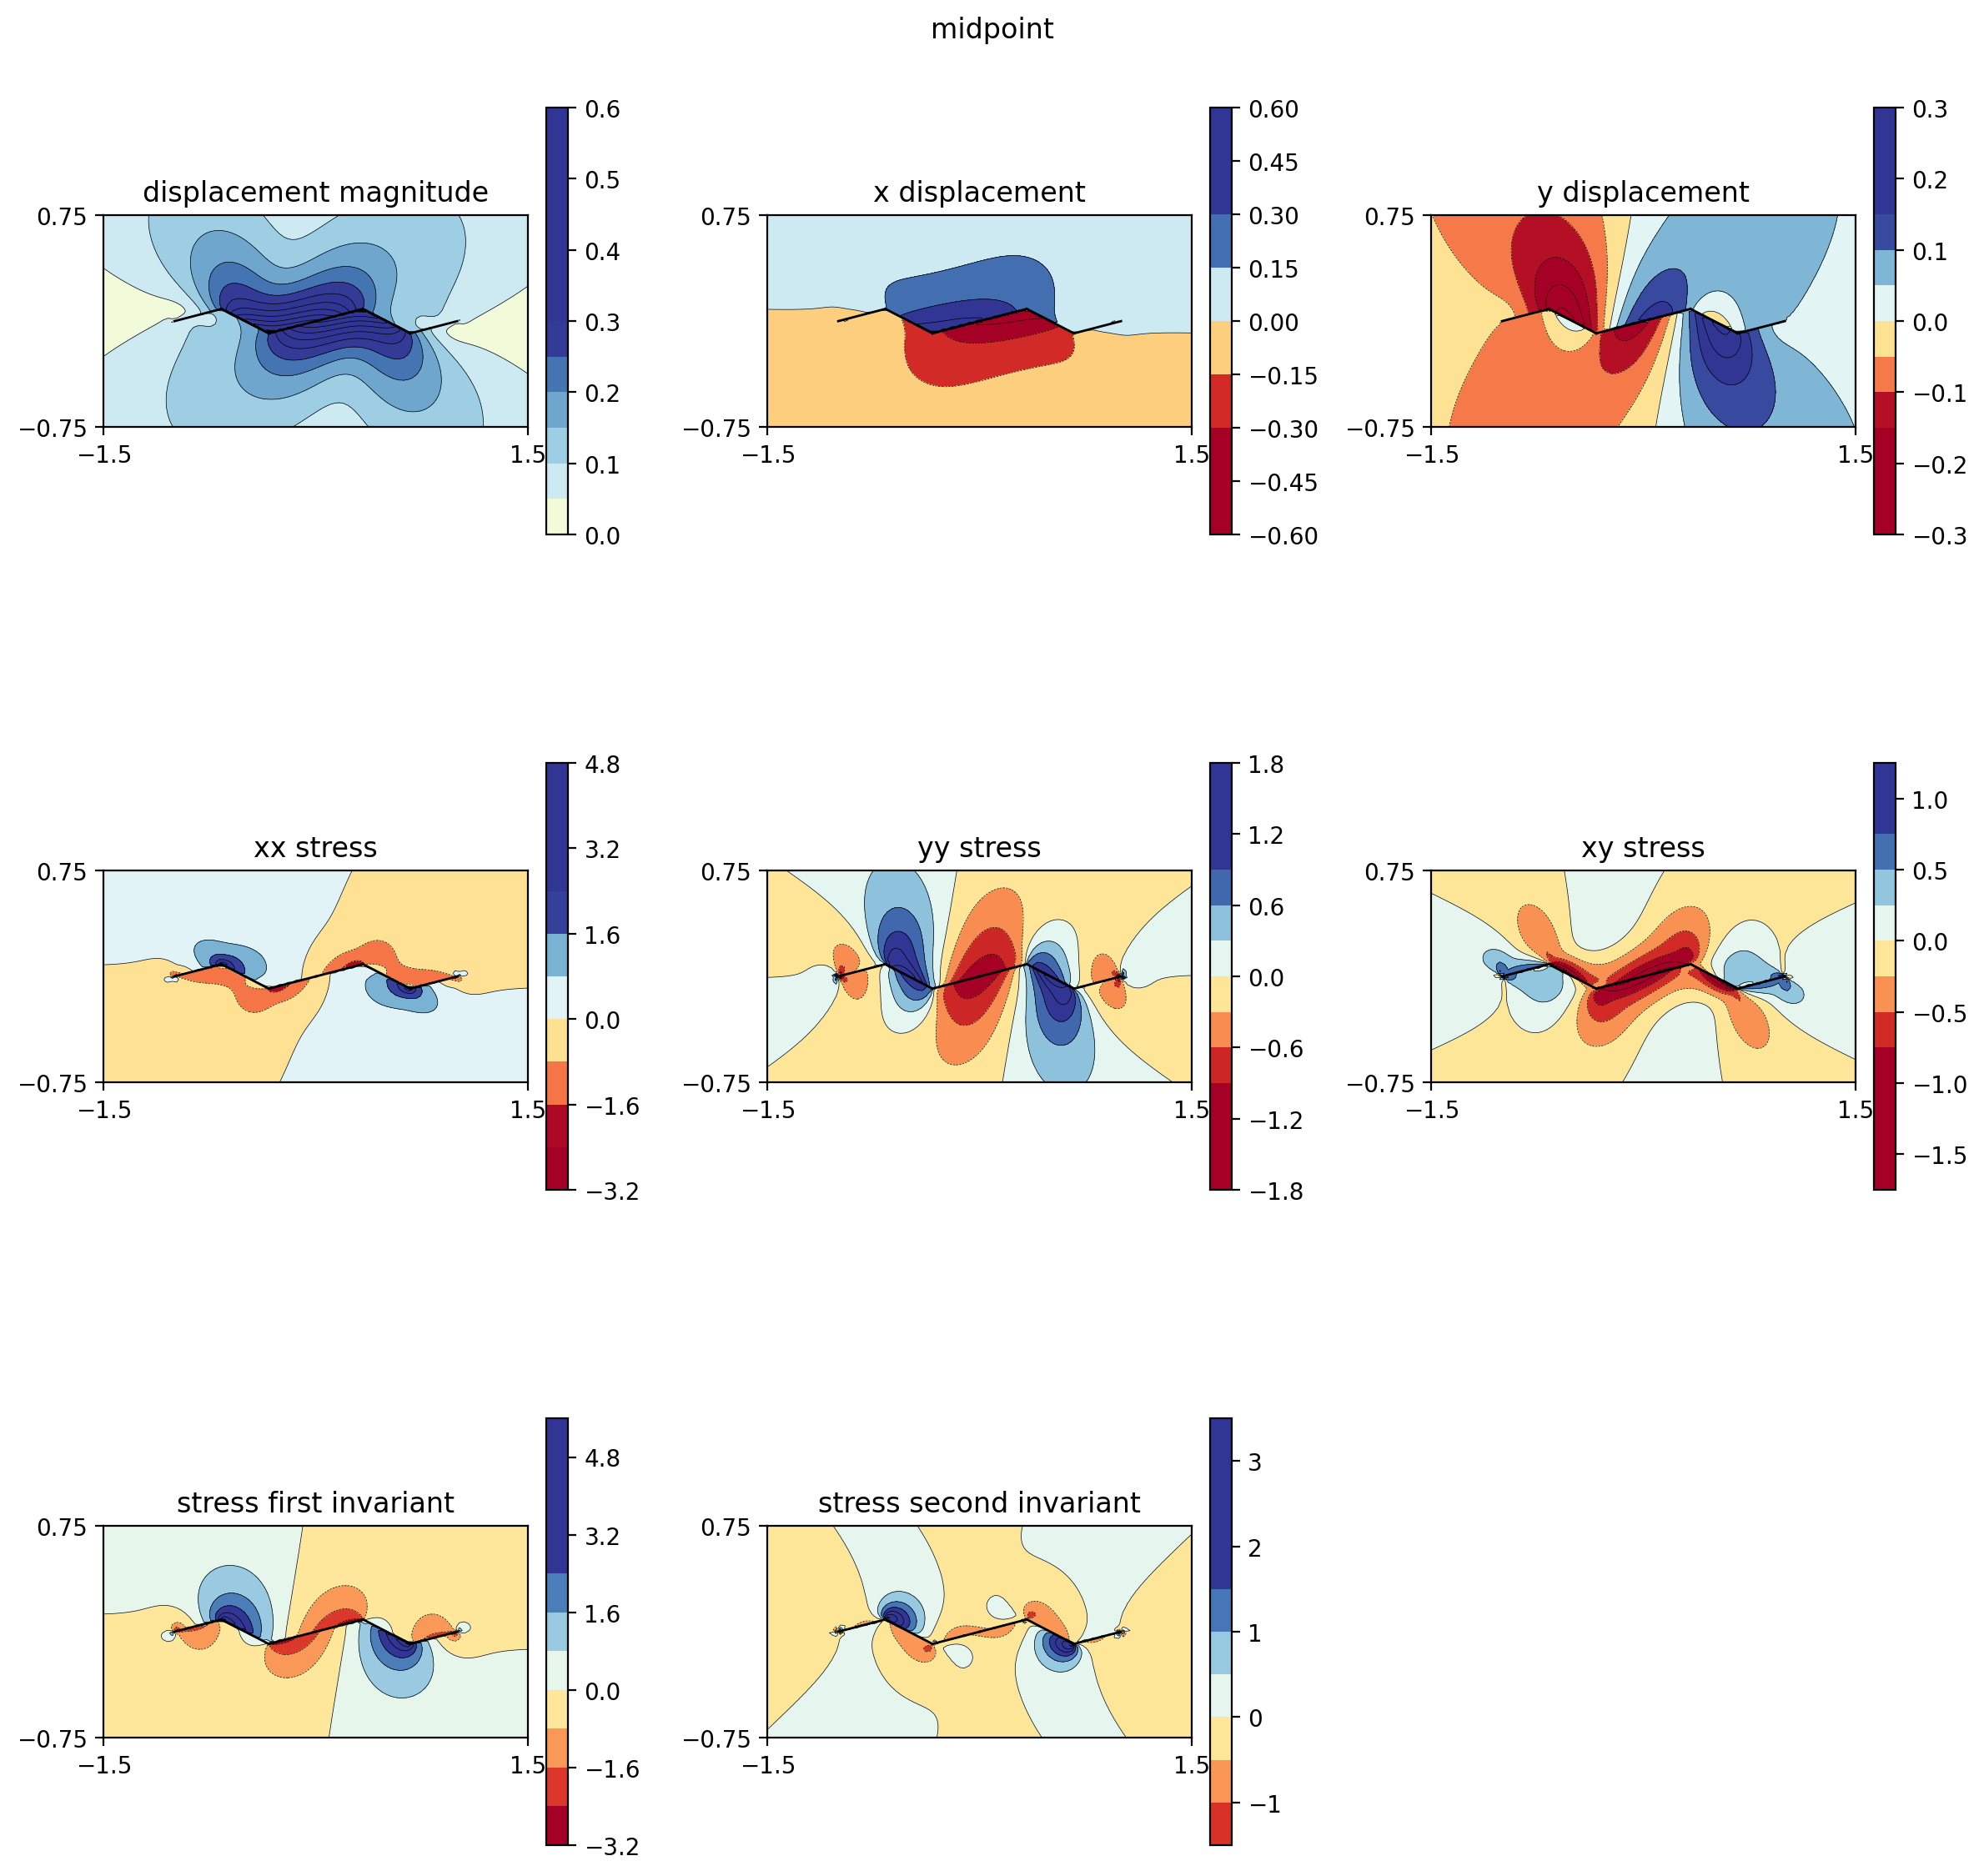

In [16]:
# Package displacements and stresses
u_total = np.zeros((2, x_obs.size))
s_total = np.zeros((3, x_obs.size))
sxx = kernels_s[0] @ quadratic_coefs_s + kernels_n[0] @ quadratic_coefs_n
syy = kernels_s[1] @ quadratic_coefs_s + kernels_n[1] @ quadratic_coefs_n
sxy = kernels_s[2] @ quadratic_coefs_s + kernels_n[2] @ quadratic_coefs_n
u_total[0, :] = ux.flatten()
u_total[1, :] = uy.flatten()
s_total[0, :] = sxx.flatten()
s_total[1, :] = syy.flatten()
s_total[2, :] = sxy.flatten()
bemcs.plot_nine_fields(elements, x_obs, y_obs, u_total, s_total, 100, "midpoint")
